In [44]:
## HFAG, Combined Gs, DGs including correlated statistical and
## systematical uncertainties 
#### Rick van Kooten, Olivier Leroy, update after ICHEP 2014 

In [45]:
# useful visualisation and numerical tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import matplotlib.patches as patches
from iminuit import Minuit, describe, Struct, util

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


- First give JpsiPhi results for LHCb,ATLAS, CMS, CDF and D0. 
- Then CP-even and CP-odd channels (e.g. Bs2KK and Bs2Jpsif0)
- Finally include the Flavour specific average

# TODO:
- formulae: double Gaussian, correl
- param val output to txt file

- input data as a single txt file? (Pros: analysis much more transparent; Cons: explanations about the origin of params missing...

# Inputs

- LHCb data: have txt file for $J/\Psi KK$
- ATLAS data: https://arxiv.org/abs/1601.03297
- CMS data: https://arxiv.org/abs/1507.07527
- CDF data: missing
- D0 data (RickVK): https://www-d0.fnal.gov/Run2Physics/WWW/results/final/B/B11C/

Below, I considerd LHCb Psi2S Phi and LHCb J/Psi KK as seperate experiments.

In [46]:

# experiments = ["LHCb", "ATLAS", "CMS", "CDF", "D0"]
# experiments = ["LHCb_Psi2S_Phi", "LHCb_JPsi_KK"]
experiments = ["LHCb_Psi2S_Phi", "LHCb_JPsi_KK", "ATLAS", "CMS", "CDF", "D0"]
# experiments = ["LHCb_Psi2S_Phi", "ATLAS"]

# params to be just read (not computed)
params = ["Gs", "Gs_estat", "Gs_esyst", "DGs", "DGs_estat", "DGs_esyst", "rho_Gs_DGs_stat", "rho_Gs_DGs_syst"]

LHCb_input = np.loadtxt("inputsHFAG_Summer2016.txt", skiprows=0) #  only J/Psi KK
# print LHCb_input


# To store params I've used a dictionary to easily access parameter values.
# Using arrays would be less transparent, because, e.g. val[3][2] is not as clear as
# val["ATLAS"]["Gs"]

# 2-dim dictionary with keys: [EXPERIMENT][PARAMETER]
val = {}
for exp in experiments:
    val[exp] = {}  # "construct" dict

# === INPUT DATA ==============================================================================
# === LHCb J/Psi KK data ===
val["LHCb_JPsi_KK"]['phis']            = LHCb_input[0]
val["LHCb_JPsi_KK"]['phis_estat']      = LHCb_input[1]
val["LHCb_JPsi_KK"]['phis_esyst']      = LHCb_input[2]
val["LHCb_JPsi_KK"]['Gs']              = LHCb_input[6]
val["LHCb_JPsi_KK"]['Gs_estat']        = LHCb_input[7]
val["LHCb_JPsi_KK"]['Gs_esyst']        = LHCb_input[8]
val["LHCb_JPsi_KK"]['DGs']             = LHCb_input[3]
val["LHCb_JPsi_KK"]['DGs_estat']       = LHCb_input[4]
val["LHCb_JPsi_KK"]['DGs_esyst']       = LHCb_input[5]
val["LHCb_JPsi_KK"]['rho_Gs_DGs_stat'] = -.45 
val["LHCb_JPsi_KK"]['rho_Gs_DGs_syst'] = +.44 
val["LHCb_JPsi_KK"]['rho_phis_DGs_stat'] = 0 
val["LHCb_JPsi_KK"]['rho_phis_DGs_syst'] = 0  # assume no corr...


# === LHCb Psi2S Phi data ===
val["LHCb_Psi2S_Phi"]['phis']            = 0.23
val["LHCb_Psi2S_Phi"]['phis_estat']      = 0.285
val["LHCb_Psi2S_Phi"]['phis_esyst']      = 0.02
val["LHCb_Psi2S_Phi"]['Gs']              = .668
val["LHCb_Psi2S_Phi"]['Gs_estat']        = .011
val["LHCb_Psi2S_Phi"]['Gs_esyst']        = .006
val["LHCb_Psi2S_Phi"]['DGs']             = .066
val["LHCb_Psi2S_Phi"]['DGs_estat']       = .0425
val["LHCb_Psi2S_Phi"]['DGs_esyst']       = .007  # ERR: in phis file = 0.006
val["LHCb_Psi2S_Phi"]['rho_Gs_DGs_stat'] = -.4
val["LHCb_Psi2S_Phi"]['rho_Gs_DGs_syst'] = 0 # before error=.007
val["LHCb_Psi2S_Phi"]['rho_phis_DGs_stat'] = 0.19
val["LHCb_Psi2S_Phi"]['rho_phis_DGs_syst'] = 0 # assume no corr...


# === ATLAS params ===
# taking this from altas run1 published paper (concerns phis vs DGs)
val["ATLAS"]['phis']            = -0.090
val["ATLAS"]['phis_estat']      = 0.078
val["ATLAS"]['phis_esyst']      = 0.041
val["ATLAS"]['Gs']              = .675
val["ATLAS"]['Gs_estat']        = .003
val["ATLAS"]['Gs_esyst']        = .003
val["ATLAS"]['DGs']             = .085  # ERR: or 0.083 (phis file)
val["ATLAS"]['DGs_estat']       = .011
val["ATLAS"]['DGs_esyst']       = .007
val["ATLAS"]['rho_Gs_DGs_stat'] = -.414
val["ATLAS"]['rho_Gs_DGs_syst'] = 0
val["ATLAS"]['rho_phis_DGs_stat'] = 0.097
val["ATLAS"]['rho_phis_DGs_syst'] = 0  # assume no corr...


# === CMS params ===
# some computations needed:
# published Phys.Lett.B 757,97 (2016), 20fb-1 8TeV only*)
# Private Email Jack, 15 july 2015, for EPS 20fb-1 8TeV result only (concerns phis vs DGs)
clight = 299.792458
ctauCMS = 447.2
ctauCMSestat = 2.9
ctauCMSesyst = 3.7

val["CMS"]['phis']             = -0.075
val["CMS"]['phis_estat']       = 0.097
val["CMS"]['phis_esyst']       = 0.031
val["CMS"]['Gs']              = clight / ctauCMS
val["CMS"]['Gs_estat']        = clight * ctauCMSestat / ctauCMS ** 2
val["CMS"]['Gs_esyst']        = clight * ctauCMSesyst / ctauCMS ** 2
val["CMS"]['DGs']             = 0.095
val["CMS"]['DGs_estat']       = 0.013 
val["CMS"]['DGs_esyst']       = 0.007

#  rho(ctau,DGs)=+0.55, see 
#  summer2015/cms_phis_DGs_Gs_run1_EPS2015_Jack.pdf, Jack Cheng
#  rho(ctau,DGs) = rho(1/Gs,DGs) = -rho(Gs,DGs)
val["CMS"]['rho_Gs_DGs_stat'] = -0.55 
val["CMS"]['rho_Gs_DGs_syst'] = 0  # assume no correlated systematics between Gs and DGs
val["CMS"]['rho_phis_DGs_stat'] = 0.10 # in phi file - misleading comment (Gs instead of phis)
val["CMS"]['rho_phis_DGs_syst'] = 0  # assume no correlated systematics between phis and DGs

# === CDF params ===
# tau=1.528 pm 0.019 (stat) pm 0.009 (syst) ps,Gs=1/tau=0.65445 pm \
# 0.0081377977577 pm 0.0038547463  e_tau/tau**2 *)

# Taken from Phys.Rev.Lett 109,171802 (2012), assuming phis Gaussian \
# and centered (phis vs DGs)
val["CDF"]['phis']            = -0.24
# val["CDF"]['phis_estat']      = 999.  # NAN?
# val["CDF"]['phis_esyst']      = 999.  # NAN?
val["CDF"]['phis_estat']      = 0.36  # Trick to get etot right (provisional!!)
val["CDF"]['phis_esyst']      = 0     # Trick
val["CDF"]['Gs']              = 0.65445026178
val["CDF"]['Gs_estat']        = 0.0081377977577
val["CDF"]['Gs_esyst']        = 0.0038547463
val["CDF"]['DGs']             = 0.068
val["CDF"]['DGs_estat']       = 0.026
val["CDF"]['DGs_esyst']       = 0.009  # ERR: 0.009 in phis file
val["CDF"]['rho_Gs_DGs_stat'] = -0.52 #  -0.5 stat only
val["CDF"]['rho_Gs_DGs_syst'] = 0 # assume no correlated systematics between Gs and DGs 

# rhostaCDF = 999.; (* -0.5 stat only *)
# rhosysCDF = 
#   999.;(* assume no correlated systematics between Gs and DGs *)
# rhoCDF = 0.0; (* Assuming from their Fig. 2 *)
val["CDF"]['rho_phis_DGs_tot'] = 0  # hard-coded

# === D0 params ===
# Taken from Phys Rev D 85, 032006 (2011)
val["D0"]['phis']             = -0.55
# phisD0estat = 999.;
# phisD0esyst = 999.;
# phisD0etot = 0.37; (* symmetrize this uncertainty *)
val["D0"]['phis_estat']       = 0.37  # trick
val["D0"]['phis_esyst']       = 0
val["D0"]['Gs']              = 0.6930
val["D0"]['Gs_estat']        = 0.017529
val["D0"]['Gs_esyst']        = 0.  # correct? Well, we only have Gs_etot -> bad coding?
val["D0"]['DGs']             = 0.163
val["D0"]['DGs_estat']       = 0.0645
val["D0"]['DGs_esyst']       = 0.0
val["D0"]['rho_Gs_DGs_stat'] = -0.05
val["D0"]['rho_Gs_DGs_syst'] = 0 # assume no correlated systematics between Gs and DGs 
# val["D0"]['rho_phis_DGs_stat'] = -0.05
# val["D0"]['rho_phis_DGs_syst'] = 0  # assume no correlated systematics between Gs and DGs 
val["D0"]['rho_phis_DGs_tot'] = -0.05  # hard-coded
# ============================================================================================


# Compute and add to `val` etots and rho_tots
for exp in experiments:
    val[exp]["Gs_etot"] = np.sqrt(val[exp]["Gs_estat"] ** 2 + val[exp]["Gs_esyst"] ** 2)
    val[exp]["DGs_etot"] = np.sqrt(val[exp]["DGs_estat"] ** 2 + val[exp]["DGs_esyst"] ** 2)
    val[exp]["phis_etot"] = np.sqrt(val[exp]["phis_estat"] ** 2 + val[exp]["phis_esyst"] ** 2)
    val[exp]["rho_Gs_DGs_tot"] = (val[exp]["Gs_estat"] * val[exp]["DGs_estat"] * val[exp]["rho_Gs_DGs_stat"] + \
                                     val[exp]["Gs_esyst"] * val[exp]["DGs_esyst"] * val[exp]["rho_Gs_DGs_syst"]) \
                                     / (val[exp]["Gs_etot"] * val[exp]["DGs_etot"])
    if exp != "CDF" and exp != "D0":  # skip hard-coded ones
            val[exp]["rho_phis_DGs_tot"] = (val[exp]["phis_estat"] * val[exp]["DGs_estat"] * val[exp]["rho_phis_DGs_stat"] + \
                                     val[exp]["phis_esyst"] * val[exp]["DGs_esyst"] * val[exp]["rho_phis_DGs_syst"]) \
                                     / (val[exp]["phis_etot"] * val[exp]["DGs_etot"])

        
# TODO: does order of things matter? When it does? Only in writing to file?   

# display the dictionary of params
# print "\n\n", val

### p.d.f.'s for the experiments

In [47]:
def gaussian2D(x, y, x0, xsig, y0, ysig, rho):
    """Joint p.d.f. of Gs and DGs for JPsi_Phi-like channels
    params:
    =======
    x, y - specify point for the function to be evaluated at
    xsig, ysig - total uncertainties of these
    rho - total rho
    """
    return 1. / (2 * np.pi * xsig * ysig * np.sqrt(1 - rho ** 2)) \
           * np.exp( (-1. / (2 * (1 - rho **2))) * ((x - x0) ** 2 / xsig ** 2 \
           + (y - y0) ** 2 / ysig ** 2 - 2 * rho * (x - x0) * (y - y0) / (xsig * ysig)) )

In [48]:
def jointPDF(x, y, pm, exps):
    """Returns product of 2-dim Gaussians from all experiments considered
    parameters:
    ===========
    x - n-dim array of arguments
    pm - tuple / list of observables of which to compute joint pdf,
             e.g. pm[0] = "Gs" and pm[1] = "DGs" for analysing these two together
    exps - list of experiments to be taken into account; allows to constrain analysis to e.g. one experiment
    """
    res = 1.
    for exp in exps:
        res *= gaussian2D(x, y, val[exp][pm[0]], val[exp][pm[0]+"_etot"],
                    val[exp][pm[1]], val[exp][pm[1]+"_etot"], val[exp]["rho_"+pm[0]+"_"+pm[1]+"_tot"])
    return res        
    

def jointPDFlog(x, y, pm, exps):
    """Returns -2*log of product of 2-dim Gaussians from all experiments considered
    parameters:
    ===========
    x - n-dim array of arguments
    pm - tuple / list of observables of which to compute joint pdf,
             e.g. pm[0] = "Gs" and pm[1] = "DGs" for analysing these two together
    exps - list of experiments to be taken into account; allows to constrain analysis to e.g. one experiment
    """
    return -2 * sum(np.log( gaussian2D(x, y, val[exp][pm[0]], val[exp][pm[0]+"_etot"],
                    val[exp][pm[1]], val[exp][pm[1]+"_etot"], val[exp]["rho_"+pm[0]+"_"+pm[1]+"_tot"]) ) 
                    for exp in exps)

# utilities
def jointPDFGsDGs_allExps(x, y):
    return jointPDF(x, y, pm=('Gs', 'DGs'), exps=all_exps) 

def jointPDFPhisDGs_allExps(x, y):
    return jointPDF(x, y, pm=('phis', 'DGs'), exps=all_exps) 

def jointPDFlogGsDGs_allExps(x, y):
    return jointPDFlog(x, y, pm=('Gs', 'DGs'), exps=all_exps) 

def jointPDFlogPhisDGs_allExps(x, y):
    return jointPDFlog(x, y, pm=('phis', 'DGs'), exps=all_exps) 

# Analysis of $\Delta \Gamma_{s}$ and $\phi_{s}^{c\bar{c}s}$

### Contour plots

dx, dy:  0.0015 0.04


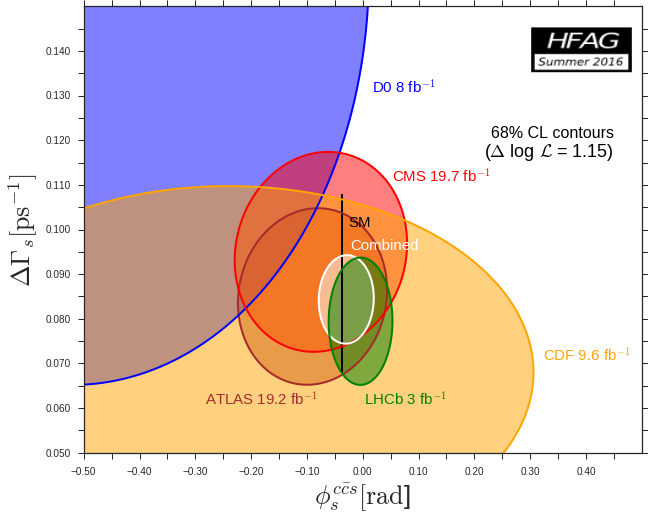

In [49]:
# general plotting settings
pylab.rcParams['figure.figsize'] = (10,8)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.style.use('seaborn-ticks')

# grid
X = np.linspace(-1.2, 0.4, 1000)
Y = np.linspace(0, 0.3, 1000)
X, Y = np.meshgrid(X, Y)

# lists of colours, labels, experiment channels, coordinates of labels
all_exps = ["LHCb_Psi2S_Phi", "LHCb_JPsi_KK", "ATLAS", "CMS", "CDF", "D0"]
lhcb_channels = all_exps[0:2]
channels = [["ATLAS"], ["D0"], ["CMS"], ["CDF"], all_exps, lhcb_channels]
labels = [r"ATLAS 19.2 fb$^{-1}$", r"D0 8 fb$^{-1}$", r"CMS 19.7 fb$^{-1}$", r"CDF 9.6 fb$^{-1}$", "Combined", r"LHCb 3 fb$^{-1}$"]
coords = [(0.42, 0.1), (0.63, 0.8), (0.73, 0.6), (0.98, 0.2), (0.6, 0.45), (0.65, 0.1)]
colors = ['brown', 'b', 'r', 'orange', 'white', 'g']

fig, ax = plt.subplots(1)

# Draw contours
for i in range(len(channels)):
    lnL = jointPDFlog(X, Y, pm=("phis", "DGs"), exps=[exper for exper in channels[i]])
    dlnL = lnL - np.min(lnL)
    ## contour 2.30 <-> 1-sigma confidence interval on 2 delta log likelihood
    ## filled in contours and then edge contours (for pretty display)
    plt.contourf(X, Y, dlnL, levels=[0, 2.30], alpha=0.5, colors=colors[i])
    plt.contour(X, Y, dlnL, levels=[0, 2.30], alpha=1, colors=colors[i], linewidths=2)
    plt.text(coords[i][0], coords[i][1], labels[i], verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color=colors[i], fontsize=15)
    
# SM theoretical prediction (all errors > 0 for convenience)
phis_SM, phis_SM_err_down, phis_SM_err_up = -0.0376, 0.0007, 0.0008
DGs_SM, DGs_SM_err_down, DGs_SM_err_up = 0.088, 0.020, 0.020

# draw rectangle for SM
def rectangle(x, xerr_down, xerr_up, y, yerr_down, yerr_up, kwargs):
    import matplotlib.patches as patches
    assert(xerr_down >= 0 and xerr_up >= 0 and yerr_down >= 0 and yerr_up >= 0)
    left_bottom = (x - xerr_down, y - yerr_down)
    dx, dy = (xerr_down + xerr_up, yerr_down + yerr_up)
    print "dx, dy: ", dx, dy
    return patches.Rectangle(left_bottom, width=dx, height=dy, **kwargs)

cosmetics = {'linewidth':1, 'edgecolor':'k', 'facecolor':'none'}
rect = rectangle(phis_SM, phis_SM_err_down, phis_SM_err_up, DGs_SM, DGs_SM_err_down, DGs_SM_err_up, cosmetics)

# Add the rectangle to the axes
ax.add_patch(rect)
plt.text(0.515, 0.5, "SM", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=15)


# Add plot description
plt.text(0.95, 0.70, "68% CL contours", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=16)
plt.text(0.95, 0.65, r"($\Delta$ log $\mathcal{L}$ = 1.15)", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=18)

# Add HFAG logo
import matplotlib.image as image
im = image.imread("hfag_logo_Summer2016.png")
ax.imshow(im, aspect='auto', extent=(0.3, 0.48, .135, .145), zorder=-1)

# Display ranges and axes ticks; axes titles
phismin, phismax, DGsmin, DGsmax = (-0.5, 0.5, 0.05, 0.15)
plt.axis([phismin, phismax, DGsmin, DGsmax])
plt.xticks(np.arange(phismin, phismax, .05))
plt.yticks(np.arange(DGsmin, DGsmax, .005))
# hide every other tick-label
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)    
# Axes settings and labels    
ax.set_autoscale_on(False)
plt.xlabel(r'$\phi_{s}^{c\bar{c}s}[\mathrm{rad}$]', fontsize=26)
plt.ylabel(r'$\Delta \Gamma_{s}[\mathrm{ps}^{-1}]$', fontsize=26)

# plt.show()
pylab.savefig('Phis_vs_DGs_ticks.png')

### Minimisation with Minuit (migrad, minos)

In [50]:
class maxlikelihood:
    """ Class to be passed to Minuit constructor. Method `__call__(self, x, y)` is to be minimised.
        Using class has advantage over simple function, because it allows to set parameters (`par` and `exps`),
        which is not possible otherwise (Minuit accepts functions with no parameters but those to be optimised))
    """
    def __init__(self, par, exps):
        self.par, self.exps = (par, exps)
        print '=' * 100
        print "Max lihelihood for parameters: ", self.par, "\nFor experiments: ", self.exps
        print '=' * 100
            
    def __call__(self, x, y):
        """ Function wrapper of function to be minimised """
        return jointPDFlog(x, y, pm=self.par, exps=self.exps)

def minimise(fun_obj, x, y, errx, erry):
    m = Minuit(fun_obj, x=x, y=y, error_x=errx, error_y=erry)
    m.migrad()
    m.minos()
    print(m.values)
    print(m.errors)

    # #covariance, correlation matrix
    # #remember y is fixed
    # print('covariance', m.covariance)
    # print('matrix()', m.matrix()) #covariance
    print('matrix(correlation=True)', m.matrix(correlation=True)) #correlation
    print "Correlation matrix: "
    m.print_matrix()
    # click the + button on the top left corner for latex code
    return m

# starting values for the Phis, DGs parameters
x, y, error_x, error_y =-0.3, 0.085, 0.0325, 0.0065

# LHCb (both channels combined)
# m_L= minimise(maxlikelihood(par=('phis', 'DGs'), exps=["LHCb_Psi2S_Phi", "LHCb_JPsi_KK"]), x=x, y=y, errx=error_x, erry=error_y)

# all experiments
m = minimise(maxlikelihood(par=('phis', 'DGs'), exps=all_exps), x=x, y=y, errx=error_x, erry=error_y)

Max lihelihood for parameters:  ('phis', 'DGs') 
For experiments:  ['LHCb_Psi2S_Phi', 'LHCb_JPsi_KK', 'ATLAS', 'CMS', 'CDF', 'D0']


/home/dawid/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: InitialParamWarning: errordef is not given. Default to 1.


FCN = -38.9353682054 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 8.22048258637e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,-0.029574,0.0325275,0,0,,,
2,y,0.0843429,0.00653976,0,0,,,


Error,-0.0325254983935,0.0325295360458
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00653384476125,0.00654569400363
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'y': 0.08434292975716355, 'x': -0.029574049456092422}
{'y': 0.00653976133012749, 'x': 0.03252750372959774}
('matrix(correlation=True)', ((1.0, 0.028312513889159965), (0.028312513889159965, 1.0)))
Correlation matrix: 


+,x,y
x,1.00,0.03
y,0.03,1.00


# Analysis of $\Delta \Gamma_{s}$ and $\Gamma_{s}$

### Input data (flavour-specific and CP-related) and p.d.f.'s

In [51]:
Gsmin = 0.62;
Gsmax = 0.75;
DGsmin = 0;
DGsmax = 0.25;

# (* tauKK constraint, only LHCb.  tauKK = tauL(1+phis^2 ys/2 )*)
# (* ol LHCb
# tauKK1=1.45218;
# etauKK1=0.04182; *)
# (* new LHCb 2014 *)
tauKK1 = 1.407;
etauKK1 = 0.017464249;
# CPeven = 1.;

# (* tauL = tauKK/(1+phis^2*DGs/(4*Gs)); *)
# (* effect of phis on tauL uncertainty is neglected! *)

# (* tauDsDs constraint, only LHCb.  tauDsDs = tauL(1+phis^2 ys/2 )*)
tauDsDs1 = 1.37900;
etauDsDs1 = 0.03106;
CPeven = 1. # DGsVersusGsSumer2016.pdf

# (* JpsiEta, LHCb ICHEP 2016, CP-even, tauL *)
tauJpsiEta1 = 1.479;
etauJpsiEta1 = 0.03573513677 # (* sqrt(0.034**2+0.011**2) *)


# (*tauJpsif0 constraint,only CDF. tauJpsif0=tauH(1-phis^2 ys/2)*)
# (* average of CDF, LHCb JpsiPiPi 1fb-1 and D0 2016 *)
tauf01 = 1.65765;
etauf01 = 0.03188 #(*symetrize the uncertainties : \
# sqrt(.5*(.11**2+.12**2))=0.1151;sqrt(0.1151**2+0.03**2)*)
# CPodd = -1.;
# (* effect of phis on tauH uncertainty is neglected *)

# (* tauJpsiKS constraint, only LHCb. tauJpsiKS = tauH(1-phis^2 ys/2)*)
tauJpsiKS1 = 1.75000;
etauJpsiKS1 = 0.13892;
CPodd = -1.;

# (* Flavour specific lifetime 2014, including tauDsD from LHCb 
# previous tau_FS=1.463 pm 0.032. New average spring 2014, including LHCb
# tau_fs(DsD)=1.52 pm 0.15 pm 0.01 ps #=1.52 pm 0.15
# =>tau_FS_2014=1.465 pm 0.031 # \
# (1/sqrt(1/.15**2+1/.032**2))*(1.52/.15**2+1.463/.032**2)
# *)

# (* ichep2014, DsD, piK and DsPi + new D0 DsMuNu. Do not used \
# Bs\[Rule]piK penguin polluted *)
tauFS1 = 1.516;
etauFS1 = 0.014;

#   Don't forget to choose phis1 
phis1 = 0.  # ????


def CP(x, y, tauCP, etauCP, phis, eta):
    """Generic joint pdf of Gs and DGs for CP-eigenstate channels (Bs2KK ??)"""
    return 1 / (np.sqrt(2 * np.pi) * etauCP) * \
    np.exp( -1. / 2 * ((2. / (2 * x + eta * y) *\
                        (1 + eta * phis ** 2 * y / (4 * x)) - tauCP) / etauCP) ** 2) 


def CP_even(x, y):
    return CP(x, y, tauDsDs1, etauDsDs1, phis1, CPeven) * CP(x, y, tauJpsiEta1, etauJpsiEta1, phis1, CPeven)


def CP_odd(x, y):
    return CP(x, y, tauf01, etauf01, phis1, CPodd)


def flavour_specific(x, y, tauFS=tauFS1, etauFS=etauFS1):
    """Joint pdf of Gs and DGs for flavour-specific lifetime tauFS"""
    return 1 / (np.sqrt(2 * np.pi) * etauFS) * \
    np.exp(-1. / 2 * ((1. / x * (1 + (y / (2 * x)) ** 2) / (1 - (y / (2 * x)) ** 2) - tauFS) / etauFS) ** 2)
    
    
def totpdf_Gs_DGs(x, y):
    """Total pdf, including JpsiKK, JpsiPipi, CP and flavour specific lifetimes"""
    return jointPDF(x, y, pm=("Gs", "DGs"), exps=all_exps) * \
    CP_even(x, y) * CP_odd(x, y) * flavour_specific(x, y, tauFS1, etauFS1)


### Contour plots

(51, 82, 4)
ratio:  0.932926829268
... =  0.621951219512


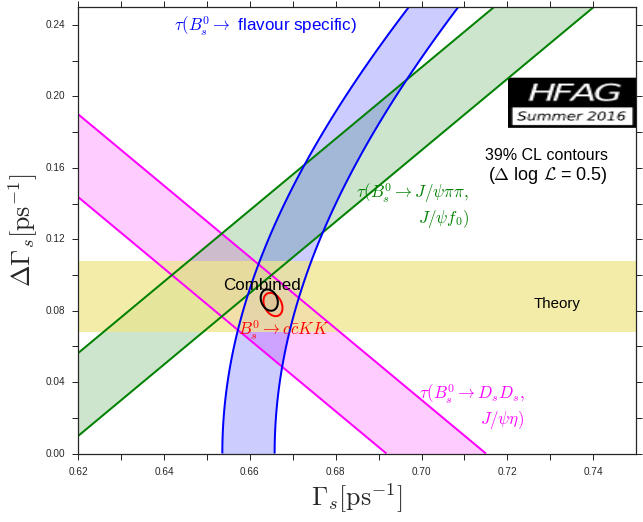

In [52]:
# grid
Gsmin, Gsmax, DGsmin, DGsmax = (0.62, 0.75, 0, 0.25)
X = np.linspace(Gsmin, Gsmax, 1000)
Y = np.linspace(DGsmin, DGsmax, 1000)
X, Y = np.meshgrid(X, Y)

# lists of colours, labels, experiment channels, coordinates of labels
channels = [all_exps] #[["ATLAS"], ["D0"], ["CMS"], ["CDF"], all_exps, lhcb_channels]
labels = [r"$B^{0}_{s}\rightarrow c\bar{c}KK$", "Combined",
          r"$\tau(B^{0}_{s} \rightarrow D_{s} D_{s},$"+"\n"+r"$J/\psi \eta)$",
          r"$\tau (B^{0}_{s} \rightarrow J/\psi \pi \pi,$"+"\n"+r"$J/\psi f_0)$",
          r"$\tau(B^{0}_{s} \rightarrow$ flavour specific)"]

coords = [(0.45, 0.25), (0.4, 0.36), (0.8, 0.05), (0.7, 0.5), (0.5, 0.93)]
colors = ['red', 'Black', 'magenta', 'green', 'blue']

# all p.d.f.'s to be displayed (-2 log computed for all except one already with -2 log)
pdfs = [jointPDFGsDGs_allExps, totpdf_Gs_DGs, CP_even, CP_odd, flavour_specific]

fig, ax = plt.subplots(1)

# Draw contours
for i in range(len(pdfs)):
    lnL = -2 * np.log(pdfs[i](X, Y))
    dlnL = lnL - np.min(lnL)
    ## contour 1 <-> 39% confidence interval on 2 delta log likelihood
    ## filled in contours and then edge contours (for pretty display)
    plt.contourf(X, Y, dlnL, levels=[0, 1.], alpha=0.2, colors=colors[i])
    plt.contour(X, Y, dlnL, levels=[0, 1.], alpha=1, colors=colors[i], linewidths=2)
    plt.text(coords[i][0], coords[i][1], labels[i], verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color=colors[i], fontsize=17)


# SM prediction
dGs_SM, dGs_err_SM = 0.088, 0.020  # ps^-1
left_bottom = (Gsmin, dGs_SM - dGs_err_SM)
width = Gsmax - Gsmin
height = 2 * dGs_err_SM
cosmetics = {'linewidth':1, 'edgecolor':'none', 'facecolor':'khaki',
             'alpha':0.75}
rec = patches.Rectangle(left_bottom, width=width, height=height, **cosmetics)

# Add the rectangle to the axes
ax.add_patch(rec)
plt.text(0.9, 0.32, s="Theory", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=15)

# Add plot description
plt.text(0.95, 0.65, "39% CL contours", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=16)
plt.text(0.95, 0.60, r"($\Delta$ log $\mathcal{L}$ = 0.5)", verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, color='k', fontsize=18)

# Add HFAG logo
import matplotlib.image as image
im = image.imread("hfag_logo_Summer2016.png")
# logo positioning (making sure height/width ratio is preserved)
print np.shape(im)
height, width, _ = np.shape(im)
xmin, xmax, ymax = (0.72, 0.75, 0.21)
ymin = ymax - float(height) / width * (xmax - xmin) * 12./8
ax.imshow(im, aspect='auto', extent=(xmin, xmax, ymin, ymax), zorder=-1)

print "ratio: ", (ymax-ymin) / (xmax-xmin)
print "... = ", 51. / 82
# Display ranges and axes ticks; axes titles
plt.axis([Gsmin, Gsmax, DGsmin, DGsmax])
plt.xticks(np.arange(Gsmin, Gsmax, .01))
plt.yticks(np.arange(DGsmin, DGsmax, .02))
# hide every other tick-label
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)    
# Axes settings and labels    
ax.set_autoscale_on(False)
plt.xlabel(r'$\Gamma_{s}[\mathrm{ps}^{-1}]$', fontsize=26)
plt.ylabel(r'$\Delta \Gamma_{s}[\mathrm{ps}^{-1}]$', fontsize=26)

# # plt.show()
pylab.savefig('Gs_vs_DGs_ticks.png')

### Minimisation with Minuit (migrad, minos)

In [53]:
# starting values for the Gs, DGs parameters
x, y, error_x, error_y =.664, .085, 0.0022, 0.0065
m = minimise(maxlikelihood(par=('Gs', 'DGs'), exps=all_exps), x=x, y=y, errx=error_x, erry=error_y)

Max lihelihood for parameters:  ('Gs', 'DGs') 
For experiments:  ['LHCb_Psi2S_Phi', 'LHCb_JPsi_KK', 'ATLAS', 'CMS', 'CDF', 'D0']


/home/dawid/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: InitialParamWarning: errordef is not given. Default to 1.


FCN = -64.572143151 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 8.82252594867e-25 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.665394,0.00221695,0,0,,,
2,y,0.0834402,0.00653203,0,0,,,


Error,-0.00221694630622,0.00221694630623
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00653202704158,0.00653202704158
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'y': 0.0834401557887632, 'x': 0.6653943296003574}
{'y': 0.006532027044003782, 'x': 0.002216946306352385}
('matrix(correlation=True)', ((1.0, -0.2913780585567062), (-0.2913780585567062, 1.0)))
Correlation matrix: 


+,x,y
x,1.00,-0.29
y,-0.29,1.00
